# An Introduction to "Consistent Bayesian" Inversion 

## Example 2: A higher dimensional problem and template for working with data sets

This tutorial shows how to perform consistent Bayesian inversion directly on any data set. 

In particular, we use a data set for the 100-dimensional example shown in  

_[***Combining Push-Forward Measures and Bayes' Rule to Construct Consistent Solutions to Stochastic Inverse Problems
***, T. Butler, J. Jakeman, T. Wildey, SIAM J. Sci. Comput., 40(2), A984–A1011](https://epubs.siam.org/doi/abs/10.1137/16M1087229)_

## Libraries

 * We make use of `numpy` to handle the sample sets defined as arrays, and we also use the `random` subpackage within `numpy` to generate random samples of various distributions.
 
 
 * We use a standard kernel density estimator in `scipy.stats` to approximate the densities on sample sets.
 
 
 * We use `matplotlib.pyplot` to visualize results.
 
 
 * We use `scipy.io` to load a data set. The `scipy.io` can read/write many data formats and is an overall useful way to connect Python scripts to computational codes written in almost any language. Read more about `scip.io` here https://docs.scipy.org/doc/scipy/reference/io.html.

In [1]:
# The libraries we will use
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, gaussian_kde as GKDE
from scipy.stats import norm 
import scipy.io as sio

## Load the data set containing both QoI and parameter samples

Loading the data set `elliptic_kde100_10k.mat` creates a dictionary where


 * QoI samples are "tagged" with the key `qq` and are a $10000\times 3$ array, but we only consider the first QoI samples defined by the first column of this array.


 * Parameter samples are "tagged" with the key `pp` and are a $10000\times 100$ array.

In [2]:
data_set = sio.loadmat('elliptic_kde100_10K.mat')
qvals = data_set['qq'] # QoI samples
qvals = qvals[:,0] # Only using first QoI here
lam = data_set['pp'] # parameter samples

## What are the observations?

While it is possible/reasonable for the observed data or a description of the observed density to be included with the data set, we instead consider the situation where observations are collected independently/separately from the experiments/simulations. 

For the sake of argument, we assume that the observations lead to a $N(0.7,0.01^2)$ density being defined on the QoI.

In [3]:
# Define an observed density
obs_vals = norm.pdf(qvals, loc=0.7, scale=1.0e-2)

## What do we need to do with the data set to construct the consistent posterior?

The fundamental assumption is that the data set we loaded comes from some ***prior*** knowledge, i.e., the parameter samples come from a prior and the QoI data are associated with these prior samples. 

All we need to do with these samples is perform density estimation on the QoI samples.

***We do not need to know anything about this prior to define the re-weighting of these samples, which subsequently means we can use this existing sample set to generate i.i.d. samples from the posterior.*** 

In [4]:
# Compute the pushforward of the prior
q_kde = GKDE( qvals, 'silverman' )

## Now we perform rejection sampling (see previous lecture for a review)

Notice how ***fast*** this is because all the computations are taking place in a 1-dimensional data space.

In [5]:
def rejection_sampling(r):
    # Perform accept/reject sampling on a set of proposal samples using
    # the weights r associated with the set of samples and return
    # the indices idx of the proposal sample set that are accepted.
    N = r.size # size of proposal sample set
    check = np.random.uniform(low=0,high=1,size=N) # create random uniform weights to check r against
    M = np.max(r)
    new_r = r/M # normalize weights 
    idx = np.where(new_r>=check)[0] # rejection criterion
    return idx

In [6]:
# Compute the posterior
r = np.divide(obs_vals,q_kde(qvals))
    
samples_to_keep = rejection_sampling(r)

post_q = qvals[samples_to_keep]
post_lam = lam[:,samples_to_keep]

accept_rate = samples_to_keep.size/lam.shape[0]
print(accept_rate)

27.72


## Don't forget to do some diagnostics

In [7]:
print(np.mean(post_q))
print(np.sqrt(np.var(post_q)))
print(np.mean(r))
print(np.mean(r*np.log(r)))

0.70001702555
0.00993200897212
0.996776630621
0.737186244586


## Visualizing results

 * We almost always start by checking the push-forwards against the observed density.  
 
 
 * If the data space is higher-dimensional, we may only visualize the marginals of the densities, or we may instead opt to visualize certain statistics of the distribution or the marginals as we show below for the 100-dimensional parameter space.

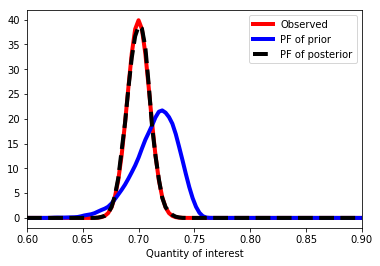

In [8]:
# Compare the observed and the pushforwards of prior and posterior
qplot = np.linspace(0.6, 0.9, num=100)
plt.clf()

q_kde_plot = q_kde(qplot)
obs_vals_plot = norm.pdf(qplot, loc=0.7, scale=1.0e-2)
postq_kde = GKDE( post_q, 'silverman' )
postq_kde_plot = postq_kde(qplot)

oplot = plt.plot(qplot,obs_vals_plot, 'r-', linewidth=4, label="Observed")
prplot = plt.plot(qplot,q_kde_plot,'b-', linewidth=4, label="PF of prior")
poplot = plt.plot(qplot,postq_kde_plot,'k--', linewidth=4, label="PF of posterior")
plt.xlim([0.6,0.9])
plt.xlabel("Quantity of interest")
plt.legend()
plt.show()

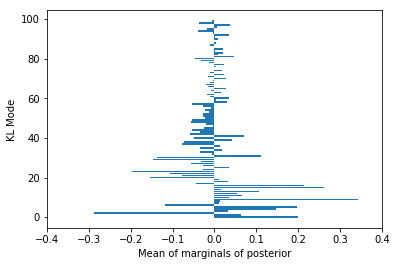

In [9]:
plt.clf()
param = np.arange(100)
plt.barh(param,np.mean(post_lam,1))
plt.xlim([-0.4,0.4])
plt.xlabel("Mean of marginals of posterior")
plt.ylabel("KL Mode")
plt.show()